# Crossentropy method

This notebook will teach you to solve reinforcement learning with crossentropy method.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: DISPLAY=:1


'bash' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

[2017-04-15 22:16:55,920] Making new env: Taxi-v2


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [3]:
policy = np.ones((n_states,n_actions), dtype=np.int)/n_actions

In [4]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [5]:
def generate_session(t_max=10**4):
    """
    Play game until end or for t_max ticks.
    returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(len(policy[s]),p=policy[s]) #<pick action from policy (at random with probabilities)>
        
        new_s,r,done,info = env.step(a)
        
        #<record prev state, action and add up reward to states,actions and total_reward accordingly>
        states.append(s)
        actions.append(a)
        
        total_reward+=r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [6]:
s,a,r = generate_session()
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) is float

# Training loop
Generate sessions, select N best and fit to those.

In [7]:
n_samples = 250  #sample this many samples
percentile = 30  #take this percent of session with highest rewards
smoothing = 0.1  #add this thing to all counts for stability

for i in range(100):
    
    %time sessions = [generate_session() for _ in range(n_samples)] #<generate n_samples sessions>]

    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))

    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session
    
#     threshold = int(n_samples*percentile/100.) #<select percentile of your samples> 
    threshold = np.percentile(batch_rewards,percentile)
    
    elite_states = batch_states[batch_rewards>threshold] #<select states from sessions where rewards are above threshold> 
    elite_actions =batch_actions[batch_rewards>threshold]   #<select actions from sessions where rewards are above threshold>
    
    elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
    #hint on task above: use np.percentile and numpy-style indexing
    
    #count actions from elite states
    elite_counts = np.zeros_like(policy)+smoothing
    
    #<count all state-action occurences in elite_states and elite_actions>
    for e in range(len(elite_states)):
        elite_counts[elite_states[e],elite_actions[e]] +=1
    

    policy = elite_counts/elite_counts.sum(1,keepdims = True)#<normalize over each state to get probabilities>
    
    
    print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))

Wall time: 3.03 s
mean reward = -773.31200	threshold = -812.0
Wall time: 2.99 s
mean reward = -721.68400	threshold = -767.0
Wall time: 2.91 s
mean reward = -684.90400	threshold = -740.0
Wall time: 3.16 s
mean reward = -648.61200	threshold = -713.0
Wall time: 2.81 s
mean reward = -596.34000	threshold = -668.0
Wall time: 3.02 s
mean reward = -549.66800	threshold = -623.0
Wall time: 3.39 s
mean reward = -504.42400	threshold = -578.0
Wall time: 2.83 s
mean reward = -457.49200	threshold = -533.0
Wall time: 3.17 s
mean reward = -426.24400	threshold = -497.0
Wall time: 2.5 s
mean reward = -371.18400	threshold = -461.0
Wall time: 2.16 s
mean reward = -319.05600	threshold = -425.0
Wall time: 1.88 s
mean reward = -266.73600	threshold = -371.0
Wall time: 1.69 s
mean reward = -227.90400	threshold = -317.0
Wall time: 1.62 s
mean reward = -190.36400	threshold = -256.3
Wall time: 1.24 s
mean reward = -145.30800	threshold = -178.0
Wall time: 983 ms
mean reward = -145.69600	threshold = -146.3
Wall time

# Approximate (deep) crossentropy method

In this section we will train a neural network policy for continuous action space game

[2017-04-15 22:17:06,893] Making new env: MountainCar-v0


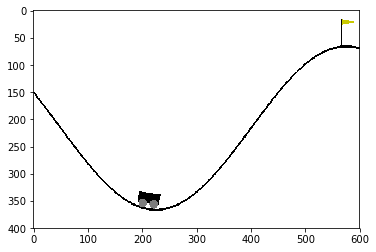

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# env = gym.make("CartPole-v0")
env = gym.make("MountainCar-v0").env 
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [12]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(80,80),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));


C:\Users\kirill.romanov\Anaconda3\envs\aind\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [17]:
def generate_session(t_max=10000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(n_actions,p=probs) #<sample action with such probabilities>
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [18]:
n_samples = 400
percentile = 90
smoothing = 0.01

for i in range(200):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_samples)]

    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))
    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session

    threshold = np.percentile(batch_rewards, percentile) #<select percentile of your samples>
    
    if np.mean(batch_rewards)>200:
        elite_states = batch_states[batch_rewards>=threshold] #<select states from sessions where rewards are above threshold> 
        elite_actions =batch_actions[batch_rewards>=threshold]   #<select actions from sessions where rewards are above threshold>
    else:
        elite_states = batch_states[batch_rewards>threshold]
        elite_actions =batch_actions[batch_rewards>threshold]
    
    print(len(elite_states), len(elite_actions))
    elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
    #elite_states: a list of states from top games
    #elite_actions: a list of actions from top games
    
    
#     <fit agent to predict elite_actions(y) from elite_states(X)>
    agent.fit(elite_states, elite_actions);


    print("epoch = %.i mean reward = %.5f\tthreshold = %.1f"%(i, np.mean(batch_rewards),threshold))

40 40
epoch = 0 mean reward = -9140.87750	threshold = -5833.8
40 40
epoch = 1 mean reward = -6809.66500	threshold = -2619.7
40 40
epoch = 2 mean reward = -3486.75750	threshold = -1505.3
40 40
epoch = 3 mean reward = -1991.94250	threshold = -1094.5
40 40
epoch = 4 mean reward = -1548.66000	threshold = -845.6
40 40
epoch = 5 mean reward = -1151.87000	threshold = -712.9
40 40
epoch = 6 mean reward = -864.14250	threshold = -559.8
40 40
epoch = 7 mean reward = -629.70000	threshold = -431.8
39 39
epoch = 8 mean reward = -550.13750	threshold = -386.0
40 40
epoch = 9 mean reward = -469.35250	threshold = -325.8
40 40
epoch = 10 mean reward = -407.60000	threshold = -285.9
39 39
epoch = 11 mean reward = -371.87750	threshold = -270.0
39 39
epoch = 12 mean reward = -318.47500	threshold = -238.0
39 39
epoch = 13 mean reward = -305.22500	threshold = -229.0
34 34
epoch = 14 mean reward = -282.45250	threshold = -200.0
39 39
epoch = 15 mean reward = -258.91000	threshold = -195.0
39 39
epoch = 16 mean re

ValueError: operands could not be broadcast together with shapes (200,2) (200,3) 

# Results

In [11]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

[2017-04-15 19:57:55,912] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-15 19:57:55,944] Starting new video recorder writing to C:\Users\kirill.romanov\Documents\GitHub\Practical_RL\week1\videos\openaigym.video.0.11064.video000000.mp4
[2017-04-15 19:57:56,750] Starting new video recorder writing to C:\Users\kirill.romanov\Documents\GitHub\Practical_RL\week1\videos\openaigym.video.0.11064.video000001.mp4
[2017-04-15 19:57:57,157] Starting new video recorder writing to C:\Users\kirill.romanov\Documents\GitHub\Practical_RL\week1\videos\openaigym.video.0.11064.video000008.mp4
[2017-04-15 19:57:57,957] Starting new video recorder writing to C:\Users\kirill.romanov\Documents\GitHub\Practical_RL\week1\videos\openaigym.video.0.11064.video000027.mp4
[2017-04-15 19:57:58,625] Starting new video recorder writing to C:\Users\kirill.romanov\Documents\GitHub\Practical_RL\week1\videos\openaigym.video.0.11064.video000064.mp4
[2017-04-15 19:57:59,497] Finished wr

In [12]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Homework part I

### Tabular correntropy method

You may have noticed that the taxi problem quickly converges from -10k to aroung -500 score (+- 500) and stays there. This is in part because taxi-v2 has some hard-coded randomness in the environment. Other reason is that the percentile was chosen poorly.

### Tasks
- __1.1__ (1 pt) Modify the tabular CEM (CrossEntropyMethod) code to plot distribution of rewards and threshold on each tick.
- __1.2__ (2 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.

```<YOUR ANSWER>```


- __1.3__ (2 pts) Tune the algorithm to end up with positive average score.
- __1.4 bonus__ (1 pt) Try to achieve a distribution where 25% or more samples score above +9.0
- __1.5 bonus__ (2 pts) Solve and upload [Taxi-v1](https://gym.openai.com/envs/Taxi-v1) to the openai gym.

It's okay to modify the existing code.


# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ Go to the [gym site](http://gym.openai.com/), register and obtain __api key__.
* __2.2__ (1 pt) Upload your result to gym via gym.upload (see Results tab above, the line you need is commented)
* __2.3__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2 (or both) and solve it.
  * For MountainCar, learn to finish it in __less than 180 steps__
  * For LunarLander, learn to get reward of __at least +50__
  * See the tips section below, it's kinda important.
  
  
* __2.4__ (1+ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.
* __Please upload the results to openai gym and send links to all submissions in the e-mail__

### Bonus tasks

* __2.5 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation_)

* __2.6 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (4+ points if it works)
  
* __2.7 bonus__ Use any deep learning framework of your choice to implement policy-gradient (see lectures) on any of those envs (4 +1 per env):
  * CartPole-v0
  * MountainCar-v0
  * LunarLander-v2
  * See __tips on policy gradient__ below.
  

* __2.8 bonus__ take your favorite deep learning framework and try to get above random in [Atari Breakout](https://gym.openai.com/envs/Breakout-v0) with crossentropy method over a convolutional network.
  * Expect at least +10 points if you get this up and running, no deadlines apply ! 
  * __See tips below on where to start, they're cruicially important__

### Tips on policy gradient

* The loss function is very similar to crossentropy method. You can get away with using rewards as  __sample_weights__.
* If your algorithm converges to a poor strategy, try regularizing with entropy or just somehow prevent agent from picking actions deterministically (e.g. when probs = 0,0,1,0,0)
* We will use `lasagne` later in the course so you can try to [learn it](http://lasagne.readthedocs.io/en/latest/user/tutorial.html).
* If you don't want to mess with theano just yet, try [keras](https://keras.io/getting-started/sequential-model-guide/) or [mxnet](http://mxnet.io/tutorials/index.html).


 ### Tips on atari breakout

* There's all the pre-processing and tuning done for you in the code below
* Once you got it working, it's probably a good idea to pre-train with autoencoder or something
* We use last 4 frames as observations to account for ball velocity
* The code below requires ```pip install Image``` and ```pip install gym[atari]```

In [ ]:
from breakout import make_breakout

env = make_breakout()
env.action_space

In [ ]:
#get the initial state
s = env.reset()
print (s.shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot first observation. Only one frame
plt.imshow(s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
#next frame
new_s,r,done, _ = env.step(env.action_space.sample())
plt.imshow(new_s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
#after 10 frames
for _ in range(10):
    new_s,r,done, _ = env.step(env.action_space.sample())

plt.imshow(new_s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
< tons of your code here or elsewhere >